In [637]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loandata/loan.csv


In [638]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
#setting to display all columns
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True
df = pd.read_csv('/kaggle/input/loandata/loan.csv', low_memory=False)
print('shape:',df.shape)

shape: (39717, 111)


# Data Understanding

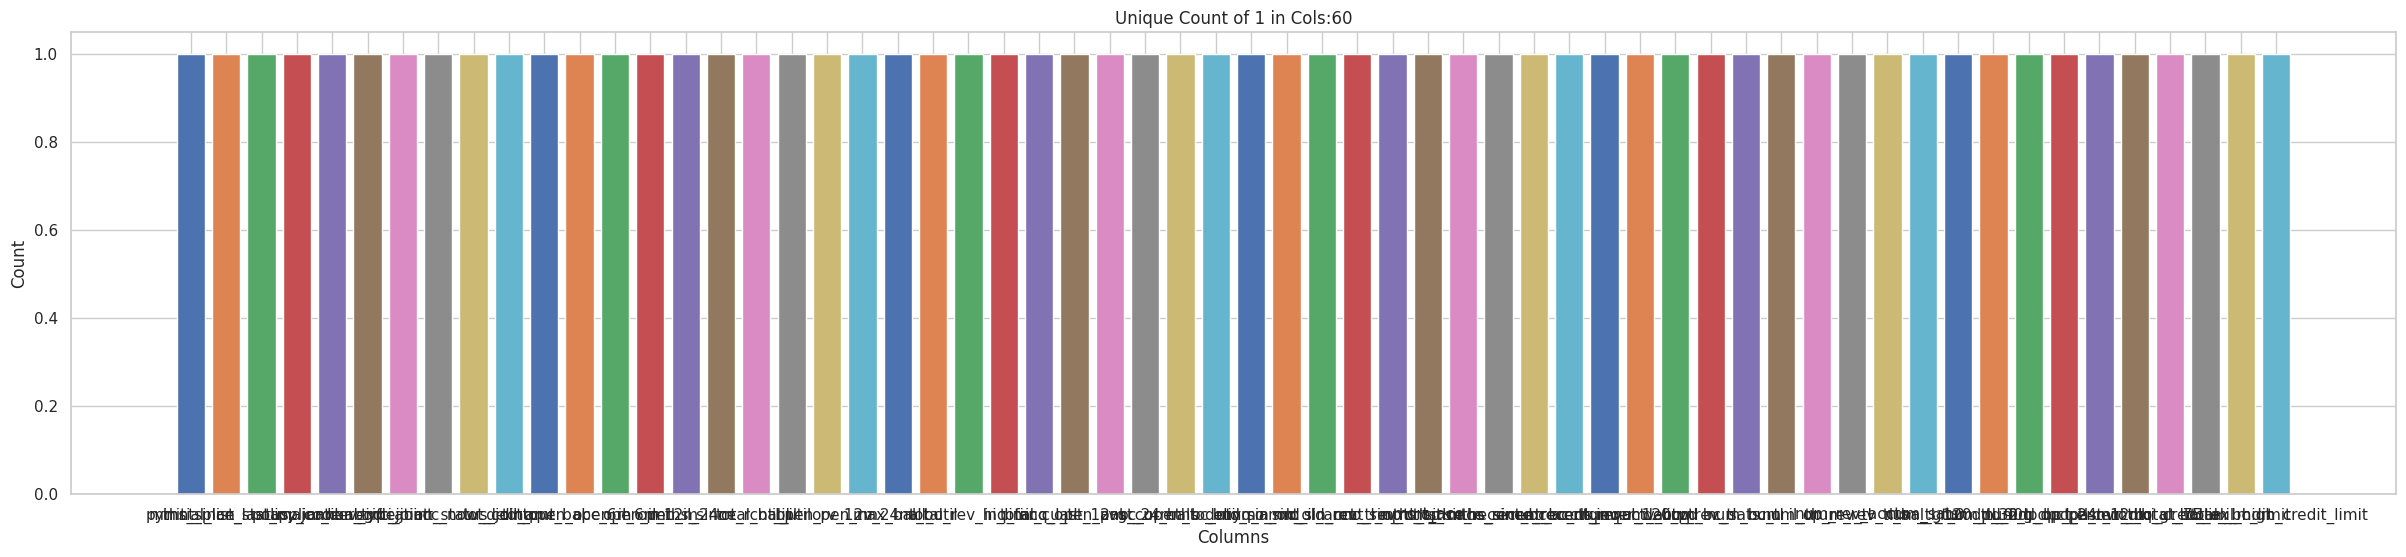

In [639]:
#df.info()
#df.dtypes.value_counts()

plt.figure(figsize=(30, 6)) 
counts = {}
for col in df.columns:
    unique_values = df[col].unique()
    if unique_values.size <= 1:
        counts[col] = unique_values.size
        # Plotting the counts
        plt.bar(col, counts[col], label=col)
# Adding labels and title
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Unique Count of 1 in Cols:{}'.format(len(counts)))
plt.show()
 

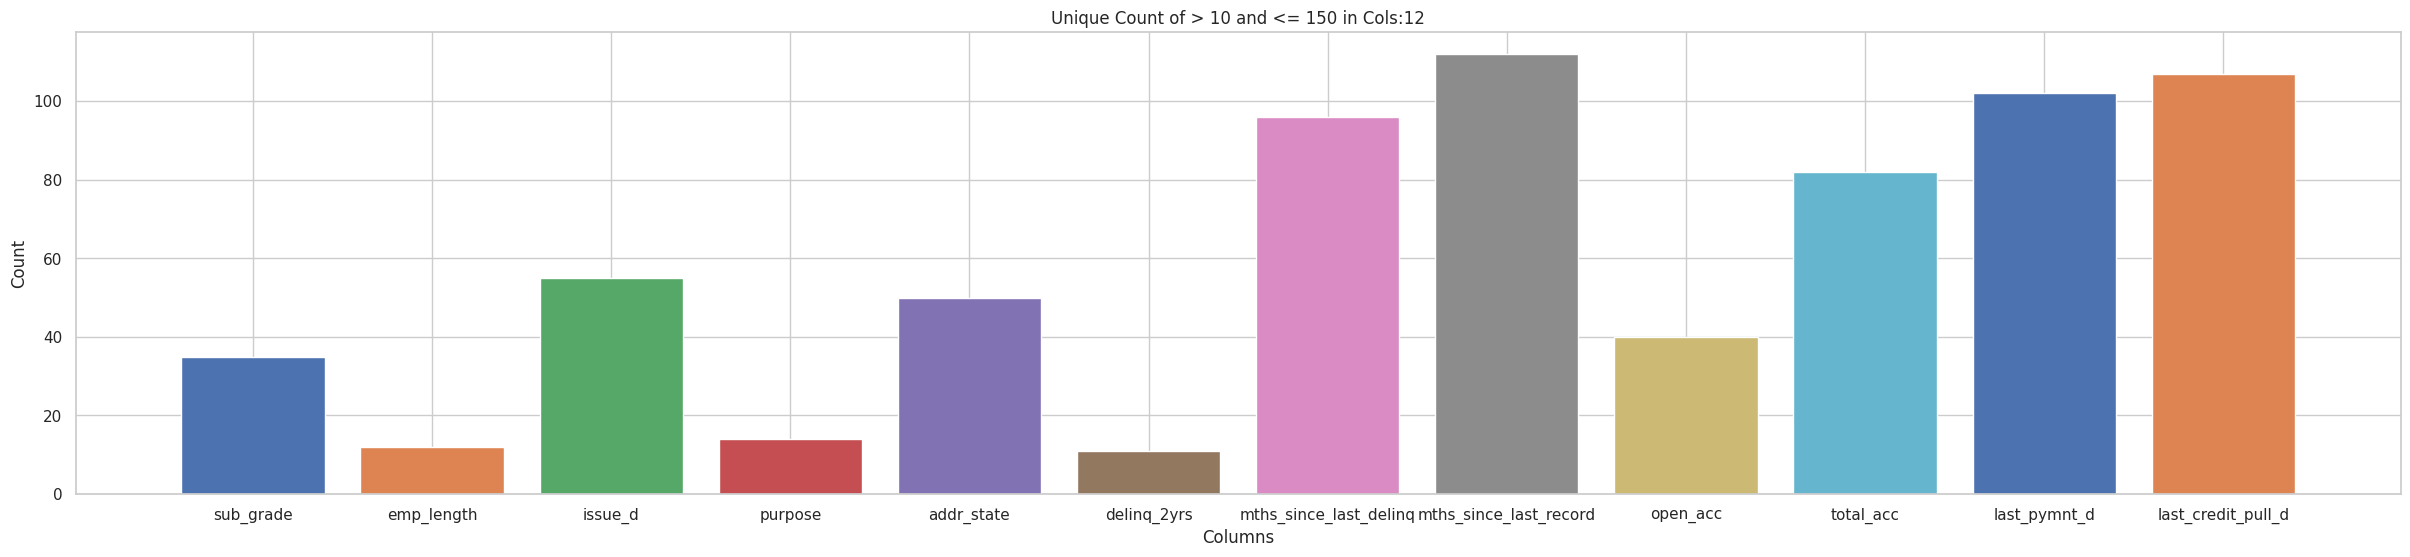

In [640]:
plt.figure(figsize=(30, 6))  
counts = {}
for col in df.columns:
    unique_values = df[col].unique()
    if unique_values.size > 10 and unique_values.size <= 150:
        counts[col] = unique_values.size
        # Plotting the counts
        plt.bar(col, counts[col], label=col)
# Adding labels and title
plt.xlabel('Columns')
plt.ylabel('Count')
plt.title('Unique Count of > 10 and <= 150 in Cols:{}'.format(len(counts)))
plt.show()

# Data Cleaning and Manipulation

Shape of data frame : (39717, 111)
### I dentified Data Cleanup requirements
  1. There are many columns with **ALL** NaN values & same value for all the records - this information is not helpful.
        The following columns have same values and hence no specific/significant value to dataset.
        * droping.... policy_code [1]
        * droping.... acc_now_delinq [0]
        * droping.... delinq_amnt [0]
  2. "term" column is String, so removing "months" from feild value of "term" and rename it as "term_in_months"
  3. "int_rate"/revol_util column has '%' - No Math metric, remove '%' from field value of 'int_rate'
  4. process emp_length for - years , + and <
    

In [641]:
# 1. There are many columns with **ALL** NaN values & same value for all the records

print('----Shape of data frame :',df.shape)
dropcols=[]
dftype_dict = df.dtypes.to_dict()
for col,typ in dftype_dict.items():
    #print(col, typ)
    if  ( len(df[col].unique()) == 1):
        #print("{} has only NaN".format(col))
        #if col in ('delinq_amnt','acc_now_delinq','policy_code'):
        #print('Dropping:{} colums with only {} as value. '.format(col,df[col].unique()[0]))
        dropcols.append(col)
df.drop(dropcols, axis=1,  inplace=True)
print('ITEM#1: Shape of data frame :',df.shape)
# 2. "term" column is String, so removing "months" from feild value of "term" and rename it as "term_in_months"
#df.term.info()
df.term = df.term.apply(lambda x: (x[:-6].lstrip().rstrip()) if ( x.lstrip().lstrip()[-6:]=='months') else x)
df.term = df.term.astype('int64')

# 3. "int_rate"/revol_util column has '%' - No Math metric, remove '%' from field value of 'int_rate'
#int_rate
#df.int_rate.info()
df.int_rate = df.int_rate.apply(lambda x: (x[:-1].lstrip().rstrip()) if (x[-1]=='%') else x)
df.int_rate = df.int_rate.astype('float64')
#revol_util
#df.revol_util.info()
df.revol_util = df.revol_util.apply(lambda x: str(x)[:-1] if(len(str(x))>0 and str(x)[-1] == '%') else -1)
df.revol_util = df.revol_util.astype('float64')
# 4. process emp_length for - years , + and < (changing < 1 year to 0 and n/a to -1)
#df.emp_length.info()
df.emp_length = df.emp_length.apply(lambda x: (str(x).replace('+ years','').replace(' years','').replace(' year','').replace('< 1','0').rstrip().lstrip().replace('nan','-1')) if True else '0')
print('Fixed value formats and converted datatypes to Numeric')

----Shape of data frame : (39717, 111)
ITEM#1: Shape of data frame : (39717, 51)
Fixed value formats and converted datatypes to Numeric


# Cleaning Data - loan_amnt (Remember to clean it)

In [642]:

# Split Dates for following columns: adding new derived columns (Month & Year)
#issue_d
#earliest_cr_line
#last_pymnt_d
#last_credit_pull_d
def split_date():
    return df['earliest_cr_line'].str.split('-', expand=True)
df[['issue_d_month', 'issue_d_year']] = df['issue_d'].str.split('-', expand=True)
df[['last_pymnt_d_month', 'last_pymnt_d_year']] = df['last_pymnt_d'].str.split('-', expand=True)
df[['last_credit_pull_d_month', 'last_credit_pull_d_year']] = df['last_credit_pull_d'].str.split('-', expand=True)
df[['earliest_cr_line_month', 'earliest_cr_line_year']] = df['earliest_cr_line'].str.split('-', expand=True)
print('shape:',df.shape ,'Note - added 8 new cols')

shape: (39717, 59) Note - added 8 new cols


In [643]:
dropcols = []
num_range_cleanup_cols = ['loan_amnt']
def fix_numeric_IQR_range(num_range_cleanup_col,df):
    #WIP - Work In Progress
    #print('Shape of data frame :',df.shape)    
    dftype_dict = df.dtypes.to_dict()
    for col,typ in dftype_dict.items():
        #print(col, typ)
        if (col in num_range_cleanup_col and typ in ('int64','float64')):
            q5,q25,q50,q75,q95 = df[col].quantile([0.05,.25,.5,.75,.95])
            high = q75+1.5*(q75-q25)
            low = q25-1.5*(q75-q25)
            #print("To fix 1.5XIQR,  {} has min of {} , max of {} and valid data range of Low:{} and high:{}".format(col, df[col].min() ,df[col].max(),low,high))
            #print('for {} the low:{} , Q5:{} , Q25:{} , Q50:{}, Q75:{} , Q95:{} and high:{}'.format(col,low,q5,q25,q50,q75,q95,high))
            if df[col].max() > high:
                #print('before-high-fix:',df.shape)
                df = df[df[col]<high]
                #print('after-high-fix:',df.shape)
            if df[col].min() < low:
                #print('before-low-fix:',df.shape)
                df = df[df[col]>low]
                #print('after-low-fix:',df.shape)
            #print('Shape of data frame after 1,5 IQR fix:',df.shape)
    return df

# Univariate Analysis for Numeric columns


<Axes: >

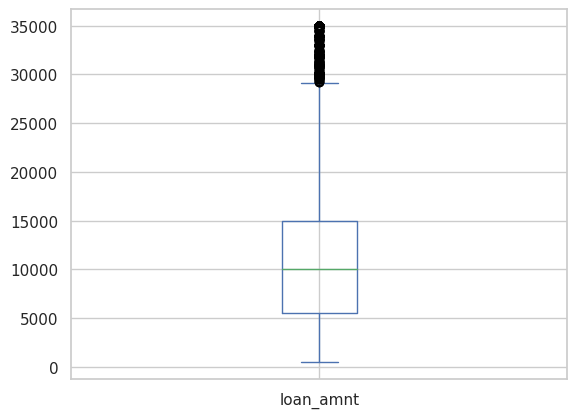

In [644]:
df.loan_amnt.plot.box()
#fix_numeric_IQR_range('loan_amnt')

<Axes: >

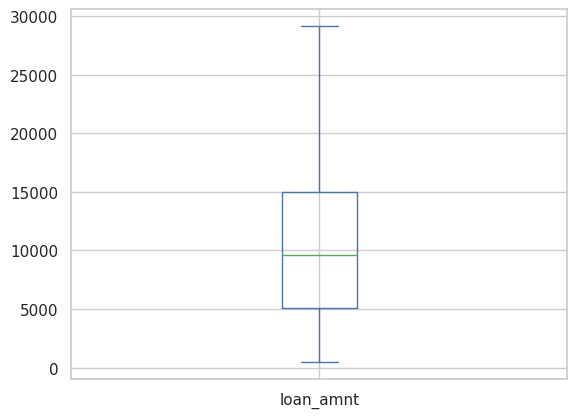

In [645]:
df = fix_numeric_IQR_range('loan_amnt',df)
df.loan_amnt.plot.box()

<Axes: >

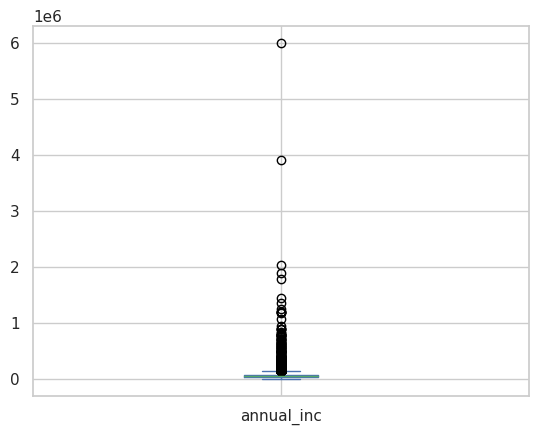

In [646]:
df.annual_inc.plot.box()

<Axes: >

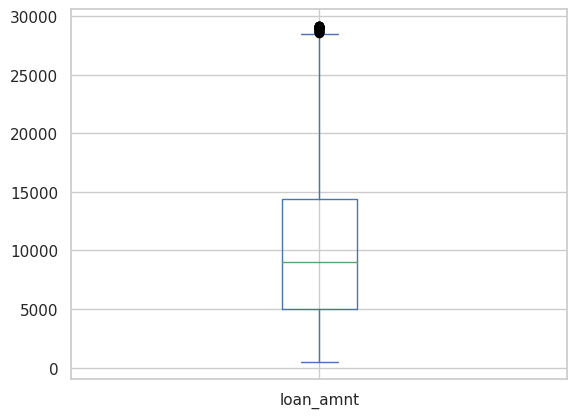

In [647]:
df = fix_numeric_IQR_range('annual_inc',df)
df.loan_amnt.plot.box()

<Axes: >

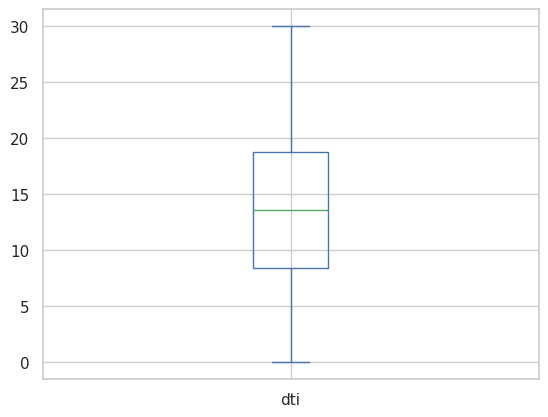

In [648]:

df.dti.plot.box()

<Axes: >

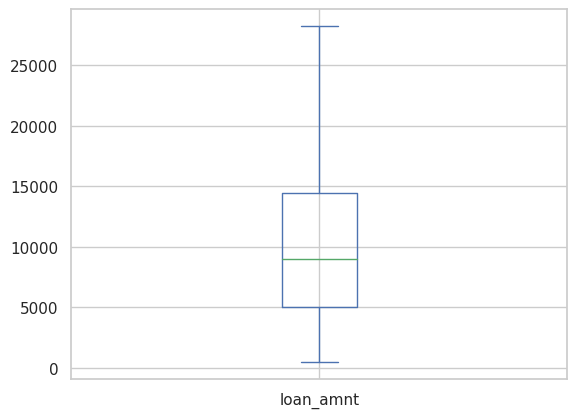

In [649]:
df = fix_numeric_IQR_range('loan_amnt',df)
df.loan_amnt.plot.box()

<Axes: >

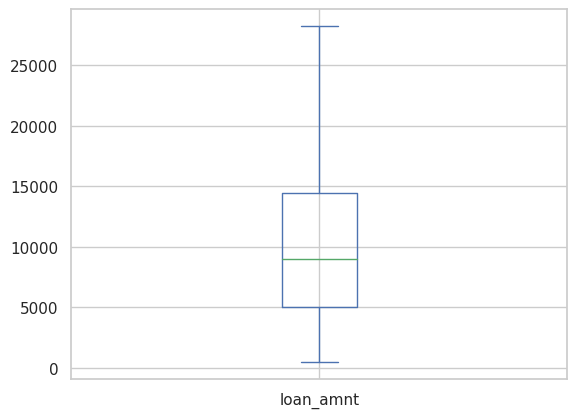

In [650]:
df.loan_amnt.plot.box()

<Axes: >

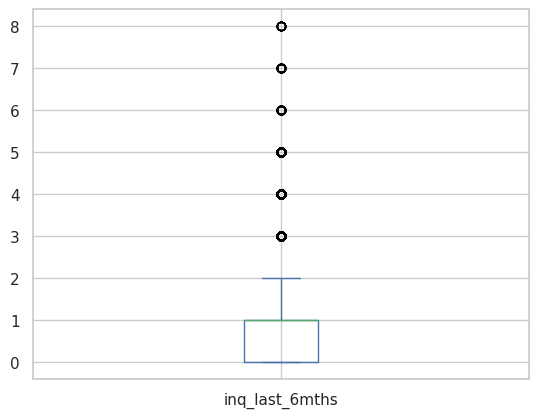

In [651]:
#inq_last_6mths
df.inq_last_6mths.plot.box()

<Axes: >

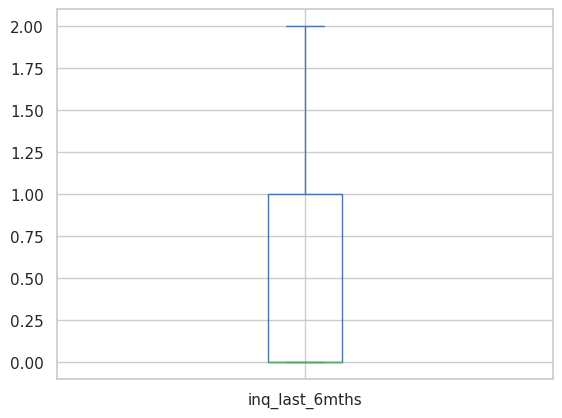

In [652]:
df = fix_numeric_IQR_range('inq_last_6mths',df)
df.inq_last_6mths.plot.box()

<Axes: >

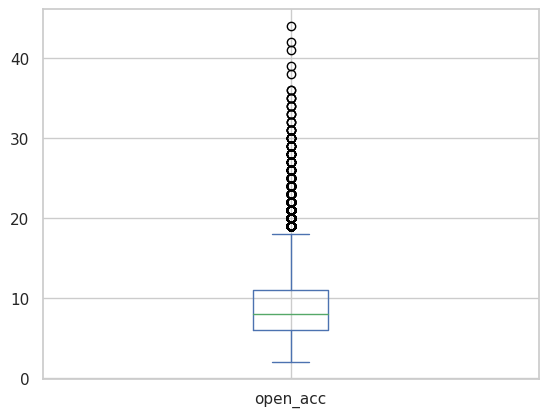

In [653]:
#open_acc
df.open_acc.plot.box()

<Axes: >

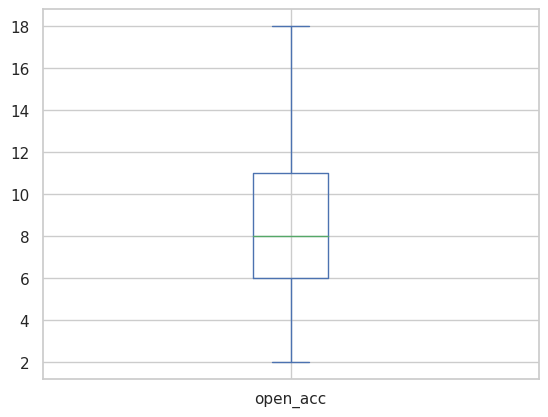

In [654]:
df = fix_numeric_IQR_range('open_acc',df)
df.open_acc.plot.box()

<Axes: >

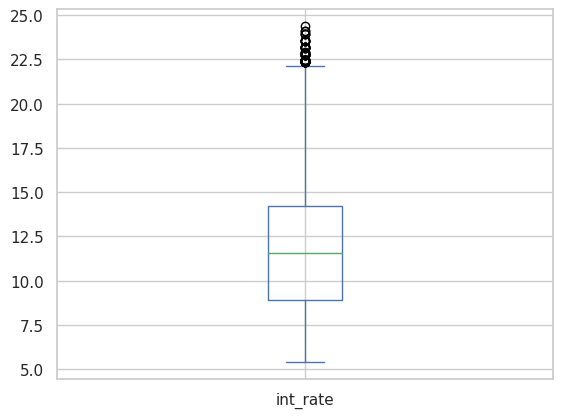

In [655]:
#int_rate
df.int_rate.plot.box()

<Axes: >

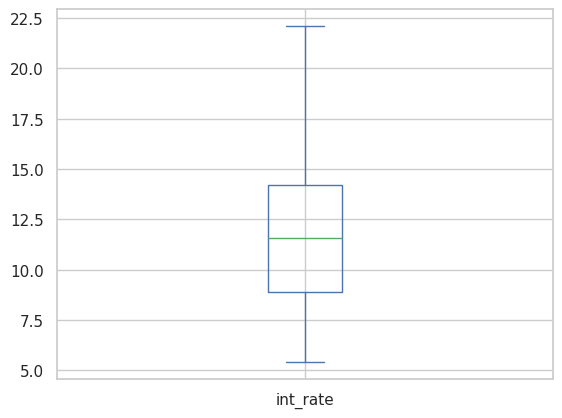

In [656]:
df = fix_numeric_IQR_range('int_rate',df)
df.int_rate.plot.box()

<Axes: >

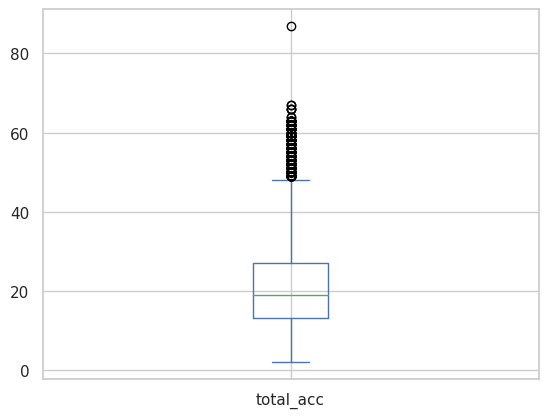

In [657]:
#total_acc
df.total_acc.plot.box()

<Axes: >

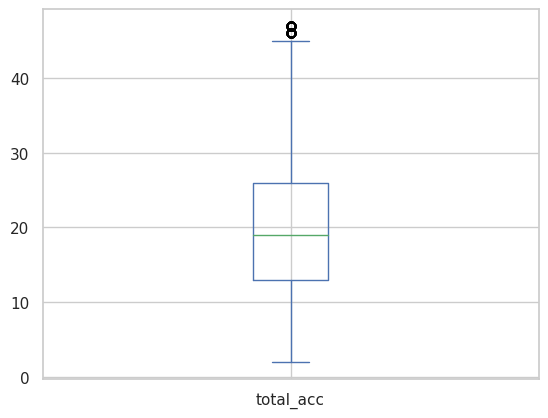

In [658]:
df = fix_numeric_IQR_range('total_acc',df)
df.total_acc.plot.box()

<Axes: >

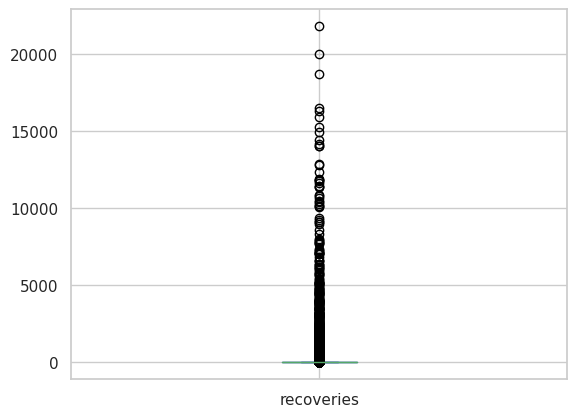

In [659]:
#recoveries
df.recoveries.plot.box()

<Axes: >

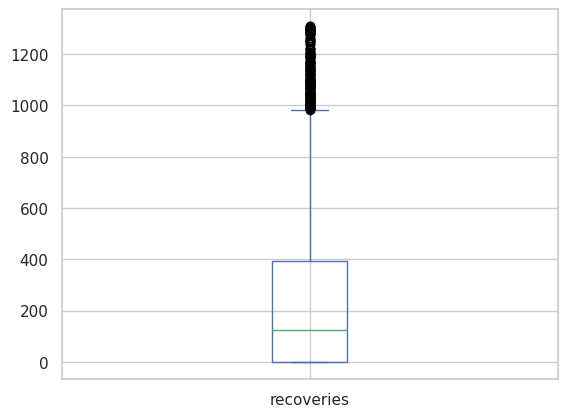

In [660]:
#for the recovery analysis - eleminate [Fully Paid , Current] as there is no recovery for these statues 
#Charged Off

df1 = df[df['loan_status']=='Charged Off']
df1 = fix_numeric_IQR_range('recoveries',df1)
df1.recoveries.plot.box()

# Plot recovery for Charged Off over time.

<Axes: xlabel='issue_d_year'>

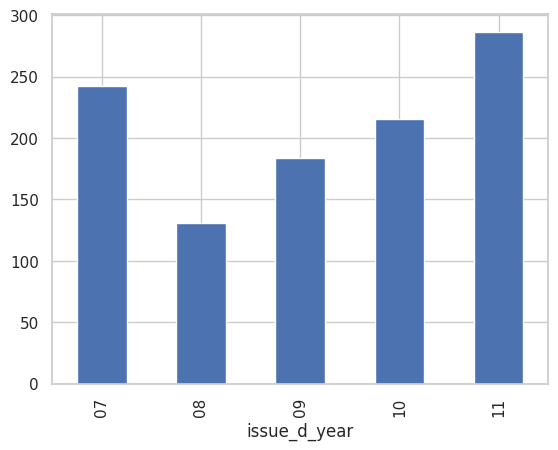

In [661]:
df1.head()
df1.groupby(by='issue_d_year')['recoveries'].mean().plot.bar()

### The graph shows that the recoveries are increasing gradually over the years from 2008 to 2011.

<Axes: xlabel='issue_d_year,issue_d_month'>

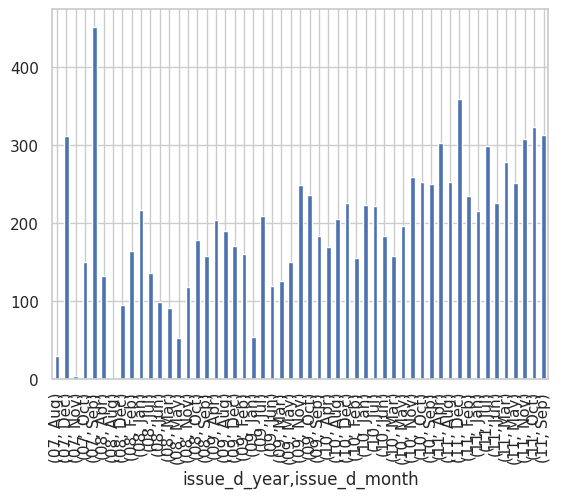

In [662]:
df1.head()
df1.groupby(by=['issue_d_year','issue_d_month'])['recoveries'].mean().plot.bar()

# emp_length vs defaults

<Axes: xlabel='emp_length'>

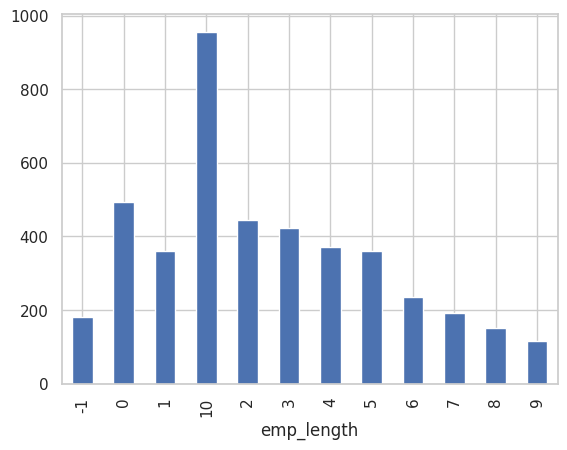

In [663]:
#emp_length vs defaults 
df2 = df[df.loan_status=='Charged Off']
df2.groupby(by=['emp_length'])['loan_status'].count().plot.bar()

<Axes: xlabel='emp_length'>

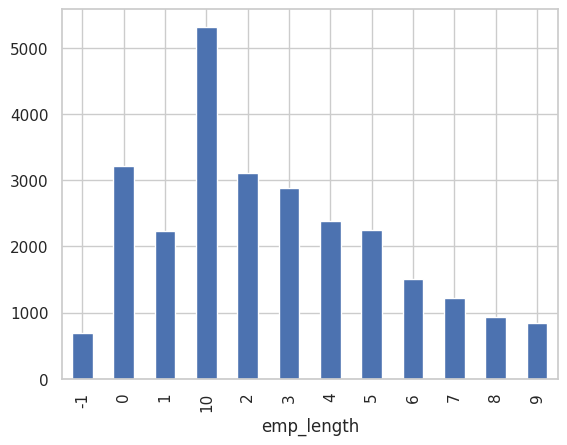

In [664]:
df2 = df[df.loan_status=='Fully Paid']
df2.groupby(by=['emp_length'])['loan_status'].count().plot.bar()

<Axes: xlabel='emp_length,loan_status'>

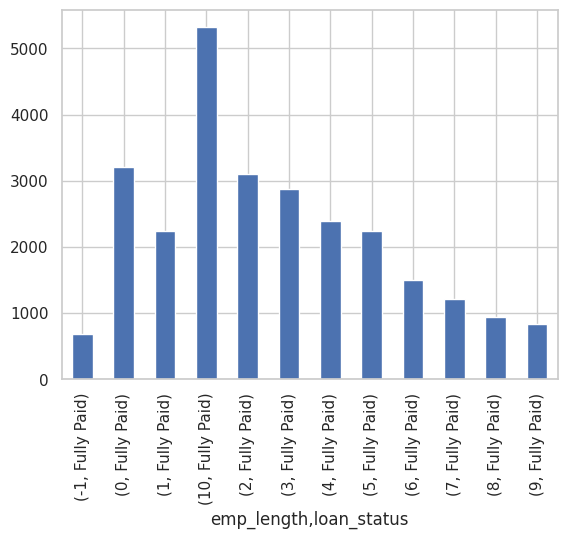

In [665]:
df2 = df[df.loan_status=='Fully Paid']
df2.groupby(by=['emp_length','loan_status'])['loan_status'].count().plot.bar()

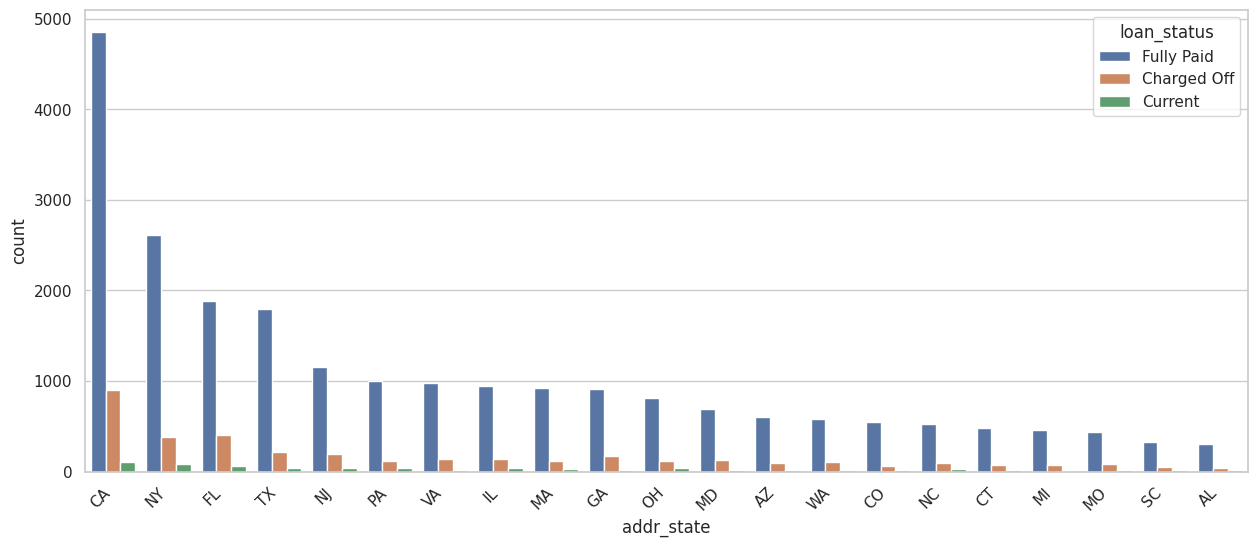

In [666]:
#'Fully Paid', 'Charged Off'
#dfplot = df[df['loan_status'] == 'Charged Off']
#dfpt = dfplot.groupby('addr_state').count().reset_index()
# Sort the DataFrame by count in descending order
#dfpt = dfpt.sort_values(by='loan_status', ascending=False)
#sns.barplot(x='addr_state', y='loan_status', data=dfpt)
#plt.show()
#------

# Group by 'addr_state' and 'loan_status' and count occurrences
dfpt=df
#removing all other states where the business is very low
dfpt = dfpt[dfpt.addr_state.isin(['CA','NY','TX','FL','NJ','PA','IL','VA','GA','MA','OH','MD','AZ','WA','CO','NC','CT','MI','MO','SC','AL'])]
#dfpt = df[df.loan_status=='Charged Off']
#dfpt = df[df.loan_status=='Fully Paid']
dfpt = dfpt.groupby(['addr_state', 'loan_status']).size().reset_index(name='count')
dfpt = dfpt.sort_values(by='count', ascending=False)
# Create the bar plot segmented by 'loan_status' with adjusted size
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6)) 
stateplt = sns.barplot(x='addr_state', y='count', hue='loan_status', data=dfpt)
#stateplt = sns.barplot(x='addr_state', y='count', data=dfpt)
# Rotate x-axis labels for better visibility

stateplt.set_xticklabels(stateplt.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show() 

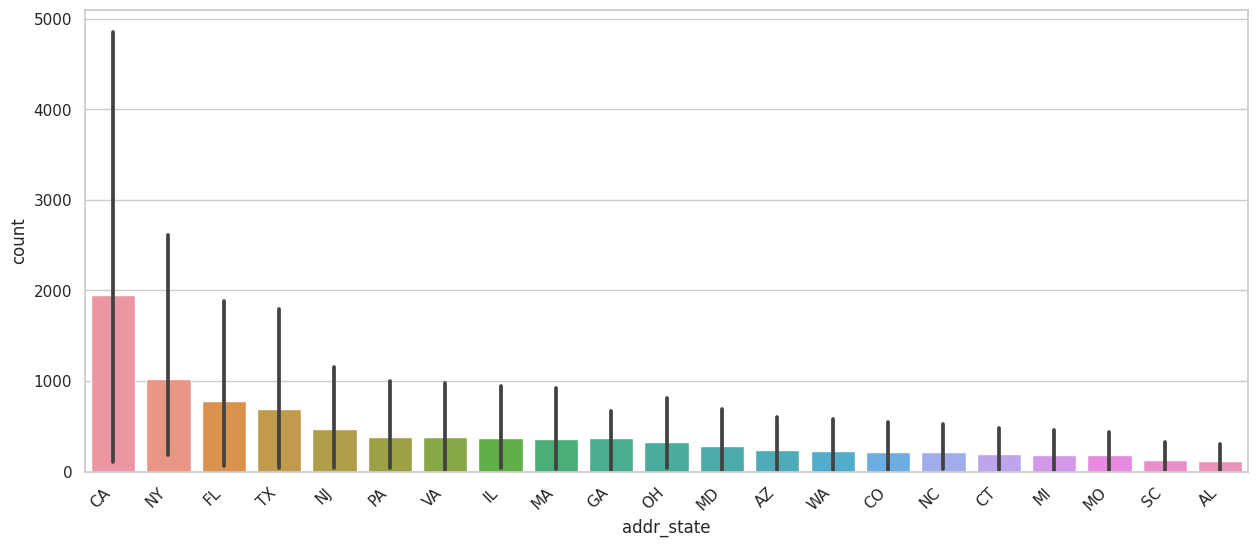

In [667]:
dfpt = dfpt[dfpt.addr_state.isin(['CA','NY','TX','FL','NJ','PA','IL','VA','GA','MA','OH','MD','AZ','WA','CO','NC','CT','MI','MO','SC','AL'])]
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6)) 
stateplt = sns.barplot(x='addr_state', y='count', data=dfpt)
stateplt.set_xticklabels(stateplt.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()        


# Ratio of charged off / fully paid by state

In [668]:
#df1['st_d_ratio'] = (dfpt.loan_status.isin(['Charged Off']).gbroupby('addr_state').count()/dfpt.loan_status.isin(['Charged Off','Fully Paid']).groupby('addr_state').count()).reset_index()
#df1.head(12)
#(reviews['province'].value_counts().head(10) / len(reviews)).plot.bar()

<Axes: xlabel='loan_status,home_ownership'>

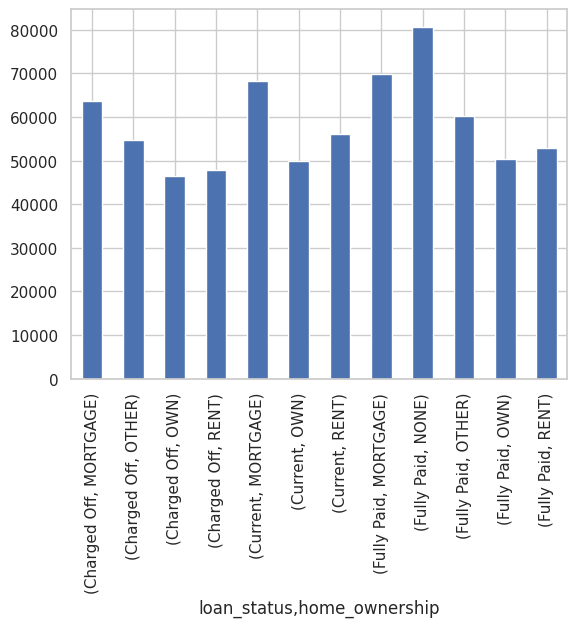

In [669]:
df.groupby(by=['loan_status','home_ownership'])['annual_inc'].mean().plot.bar()
#df.groupby(by=['loan_status','home_ownership'])['loan_status'].count()

Reducing the interest rate might help customers to make them pay the loans.

<Axes: xlabel='loan_status'>

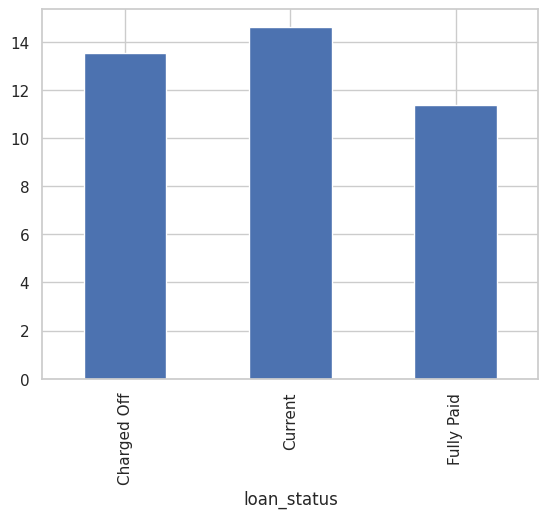

In [670]:
df.groupby(by='loan_status')['int_rate'].mean().plot.bar()

<Axes: xlabel='loan_status,issue_d_year'>

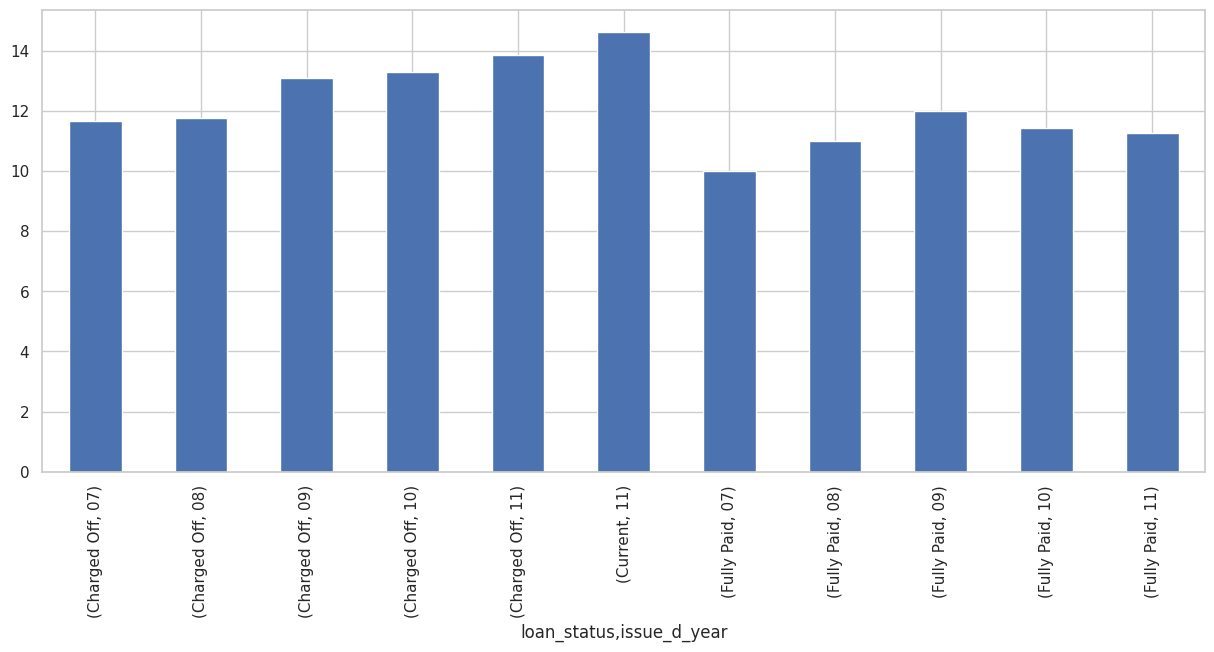

In [671]:
#sns.set(style="whitegrid")
plt.figure(figsize=(15, 6)) 
df.groupby(by=['loan_status','issue_d_year'])['int_rate'].mean().plot.bar()

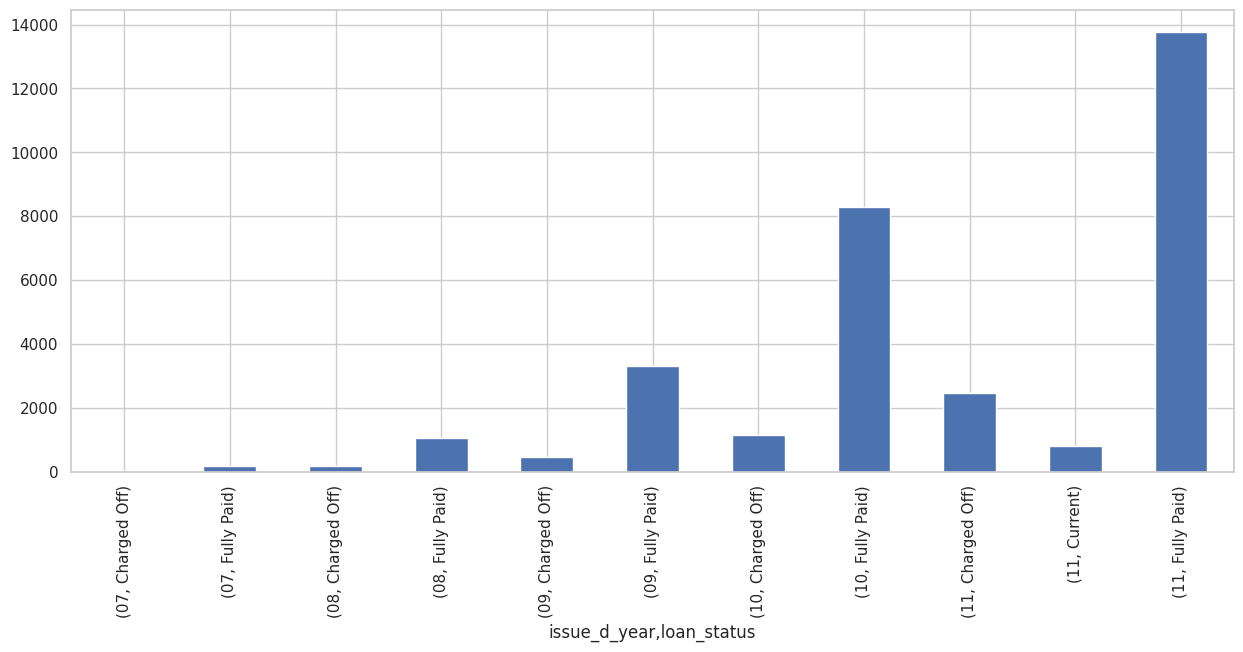

In [672]:
dfpt = dfpt[dfpt.addr_state.isin(['CA','NY','TX','FL','NJ','PA','IL','VA','GA','MA','OH','MD','AZ','WA','CO','NC','CT','MI','MO','SC','AL'])]
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6)) 
df.groupby(by=['issue_d_year','loan_status'])['id'].count().plot.bar()
plt.show()        

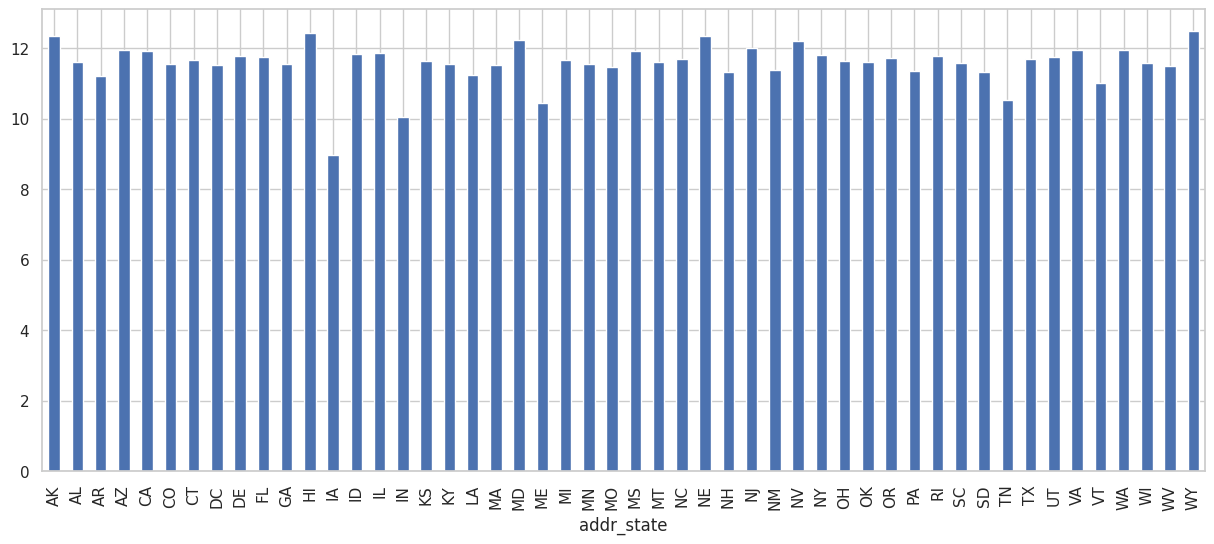

In [673]:
#dfpt = dfpt[dfpt.addr_state.isin(['CA','NY','TX','FL','NJ','PA','IL','VA','GA','MA','OH','MD','AZ','WA','CO','NC','CT','MI','MO','SC','AL'])]
dfpt = dfpt[dfpt.addr_state.isin(['CA'])]
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6)) 
df.groupby(by=['addr_state'])['int_rate'].mean().plot.bar()
plt.show()  

# loan amount vs no.of years

In [674]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens,issue_d_month,issue_d_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,earliest_cr_line_month,earliest_cr_line_year
0,1077501,1296599,5000,5000,4975.0,36,10.65,162.87,B,B2,NaN,10,RENT,24000.0,Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.7,9,0.00,0.00,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.0,Jan-15,171.62,NaN,May-16,0.0,0.0,0.0,0.0,Dec,11,Jan,15,May,16,Jan,85
2,1077175,1313524,2400,2400,2400.0,36,15.96,84.33,C,C5,NaN,10,RENT,12252.0,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.5,10,0.00,0.00,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.0,Jun-14,649.91,NaN,May-16,0.0,0.0,0.0,0.0,Dec,11,Jun,14,May,16,Nov,01
3,1076863,1277178,10000,10000,10000.0,36,13.49,339.31,C,C1,AIR RESOURCES BOARD,10,RENT,49200.0,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21.0,37,0.00,0.00,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.0,Jan-15,357.48,NaN,Apr-16,0.0,0.0,0.0,0.0,Dec,11,Jan,15,Apr,16,Feb,96
4,1075358,1311748,3000,3000,3000.0,60,12.69,67.79,B,B5,University Medical Group,1,RENT,80000.0,Source Verified,Dec-11,Current,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0,Jan-96,0,38.0,NaN,15,0,27783,53.9,38,524.06,524.06,3513.330000,3513.33,2475.94,1037.39,0.00,0.0,0.0,May-16,67.79,Jun-16,May-16,0.0,0.0,0.0,0.0,Dec,11,May,16,May,16,Jan,96
6,1069639,1304742,7000,7000,7000.0,60,15.96,170.08,C,C5,Southern Star Photography,8,RENT,47004.0,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/18/11 > I am planning o...,debt_consolidation,Loan,280xx,NC,23.51,0,Jul-05,1,NaN,NaN,7,0,17726,85.6,11,0.00,0.00,10110.840000,10110.84,6985.61,3125.23,0.00,0.0,0.0,May-16,1313.76,NaN,May-16,0.0,0.0,0.0,0.0,Dec,11,May,16,May,16,Jul,05


# df.emp_title.unique().size is 23609 and will not get any data from this
Need to process text values - standardise
* lower
* remove multiple spaces

In [675]:
df.emp_title.unique().size
#emp_title vs loan_status
#sns.set(style="whitegrid")
#plt.figure(figsize=(15, 6))  
#df.groupby(by=['emp_title','loan_status'])['id'].count().plot.bar()
#plt.show()    

23609

In [676]:
import re
def process_string(input_string):
    # convert to lowercase and Remove multiple spaces 
    lowercase_string = str(input_string).lower()
    processed_string = re.sub(' +', ' ', str(lowercase_string))
    return processed_string
df.emp_title = df.emp_title.astype('string')     
df.emp_title = df.emp_title.apply(lambda x:   process_string(x))
df.emp_title.value_counts()
#df.emp_title.unique().size

emp_title
<na>                            1908
us army                          166
bank of america                  113
walmart                           67
at&t                              65
                                ... 
affinity circles                   1
benzie county sheriff office       1
ancon marine                       1
carmax autosupestore               1
evergreen center                   1
Name: count, Length: 22541, dtype: int64

In [677]:
#sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))  
#df.emp_title.value_counts().plot.bar()
df.emp_title.tail()

39711           a. f. wolfers, inc.
39712               fisite research
39713    squarewave solutions, ltd.
39714                          <na>
39716              evergreen center
Name: emp_title, dtype: object

<Figure size 1500x600 with 0 Axes>

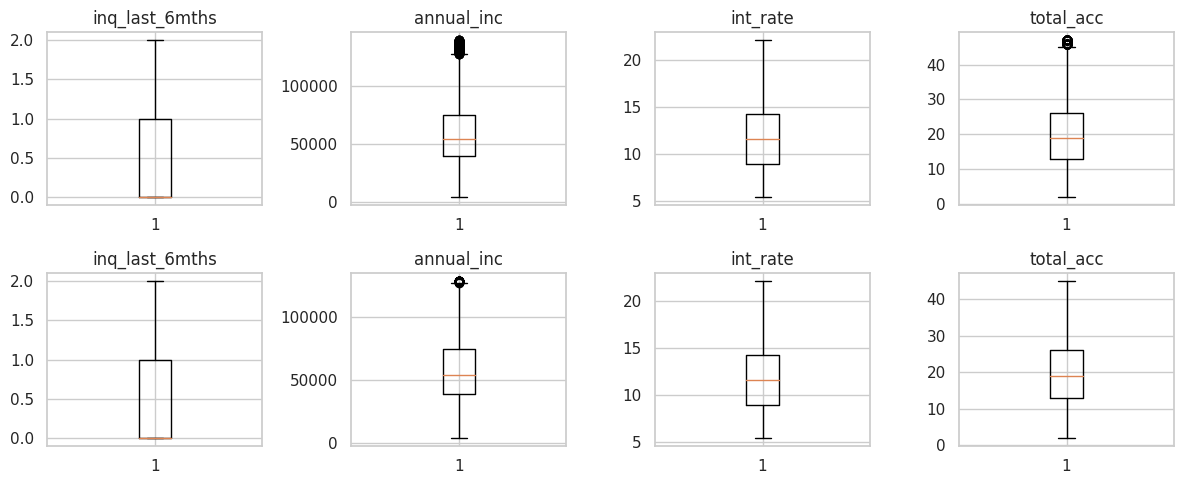

In [678]:
fig, axs = plt.subplots(2, 4, figsize=(12, 5))
#columns to plot
#total_acc, *int_rate, installment, *annual_inc
#col_array = ["total_acc","int_rate","annual_inc","installment"] - did not work and ((((recoveries *** Special Case))))
col_array = ['inq_last_6mths','annual_inc','int_rate','total_acc']# ,'open_acc','installment','int_rate']
for i, col in enumerate(col_array):
    ax = axs[0, i%4]
    ax.boxplot(df[col])
    ax.set_title(col)

for i, col in enumerate(col_array):
    df = fix_numeric_IQR_range(col,df)
    ax = axs[1, i%4]
    ax.boxplot(df[col])
    ax.set_title(col)

plt.tight_layout()
plt.show()


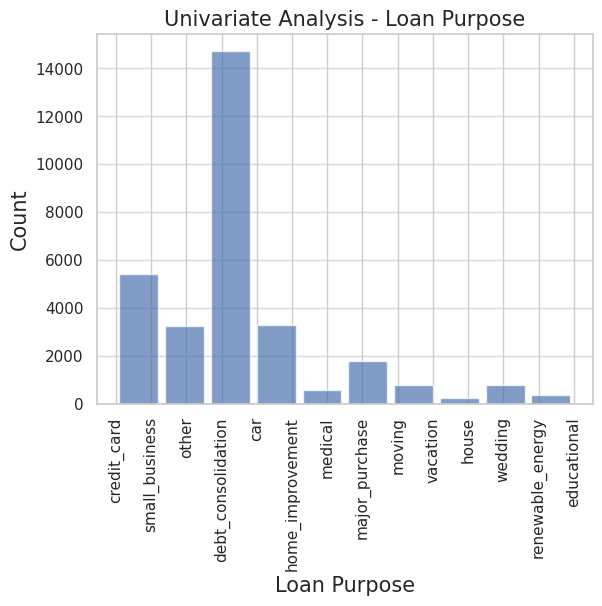

In [679]:
plt.hist(df['purpose'], rwidth=0.85, alpha=0.7)
plt.xlabel('Loan Purpose', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid(axis='y',alpha=0.75)
plt.xticks(rotation='vertical')
plt.title('Univariate Analysis - Loan Purpose', fontsize=15)
plt.show()

# Univariate Analysis

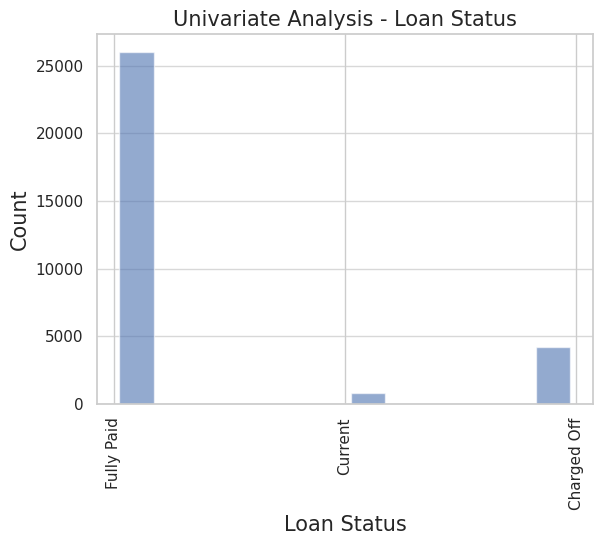

In [680]:
plt.hist(df['loan_status'], rwidth=0.75, alpha=0.6)
plt.xlabel('Loan Status', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid(axis='y',alpha=0.75)
plt.xticks(rotation='vertical')
plt.title('Univariate Analysis - Loan Status', fontsize=15)
plt.show()

In [681]:
df_fp = df[df.loan_status == 'Fully Paid']
df_co = df[df.loan_status == 'Charged Off']
df_c = df[df.loan_status == 'Current']
fpp = (df_fp.loan_status.count()/df.loan_status.count())*100
cop = (df_co.loan_status.count()/df.loan_status.count())*100
cp = (df_c.loan_status.count()/df.loan_status.count())*100
print('{} of customers are Fully Paid,{} are Charged Off and {} are Current'.format(fpp,cop,cp))

83.76725774788402 of customers are Fully Paid,13.642068676986451 are Charged Off and 2.5906735751295336 are Current


most of the customers are paying the loans.
82.96% of customers are Fully Paid,14.16% are Charged Off and 2.87% are Current


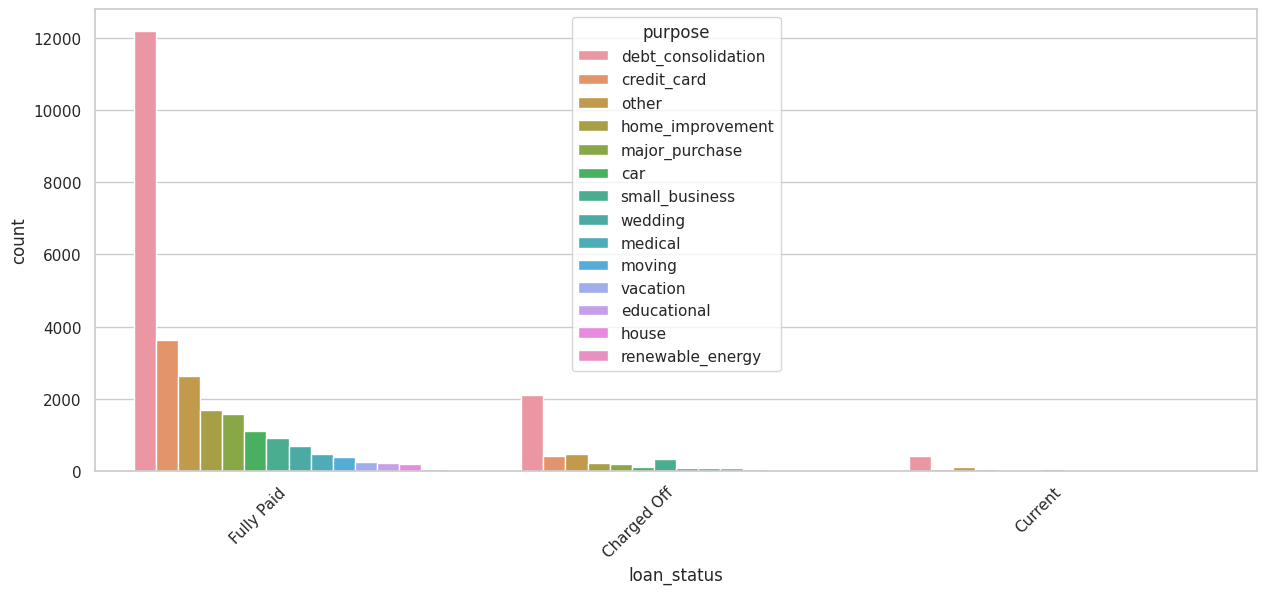

In [682]:

df_purpose_ls = df.groupby(['purpose', 'loan_status']).size().reset_index(name='count')
df_purpose_ls = df_purpose_ls.sort_values(by='count', ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))  
stateplt = sns.barplot(x='loan_status', y='count', hue='purpose', data=df_purpose_ls)


stateplt.set_xticklabels(stateplt.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show() 

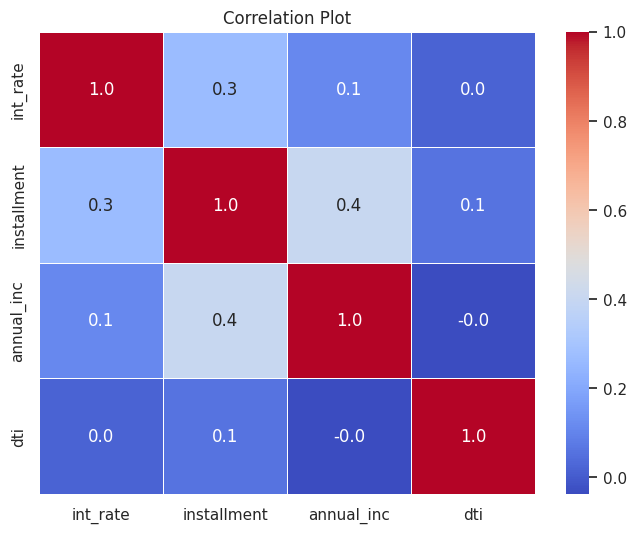

In [683]:

corr = df_co[['int_rate', 'installment', 'annual_inc', 'dti']].fillna(0).corr()
#sns.heatmap(corr)
# Create a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.4)
plt.title('Correlation Plot')
plt.show()

* most of the customers are paying the loans.
  82.96% of customers are Fully Paid,14.16% are Charged Off and 2.87% are Current
* The loan businuss looks to be slowing, as we see only 2.87% are currently paying.

* top 2 resons loans are taken are due to - debt_consolidation & to pay of credit cards
* To drive the lending business, it is worth to try selling loans to people with high interest credit cards. 
## with a segmented and multivariate analysis:
* it is found that Everyone applying with Purpose of "credit_card" are also "Charged Off" [TRUE]


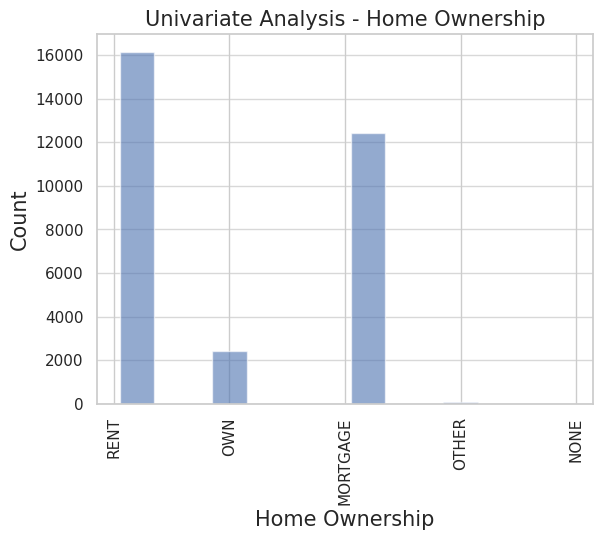

In [684]:
plt.hist(df['home_ownership'], rwidth=0.75, alpha=0.6)
plt.xlabel('Home Ownership', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid(axis='y',alpha=0.75)
plt.xticks(rotation='vertical')
plt.title('Univariate Analysis - Home Ownership', fontsize=15)
plt.show()

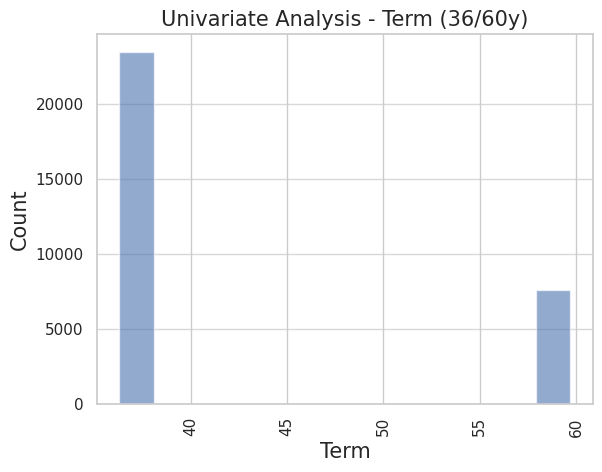

In [685]:
plt.hist(df['term'], rwidth=0.75, alpha=0.6)
plt.xlabel('Term', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid(axis='y',alpha=0.75)
plt.xticks(rotation='vertical')
plt.title('Univariate Analysis - Term (36/60y)', fontsize=15)
plt.show()

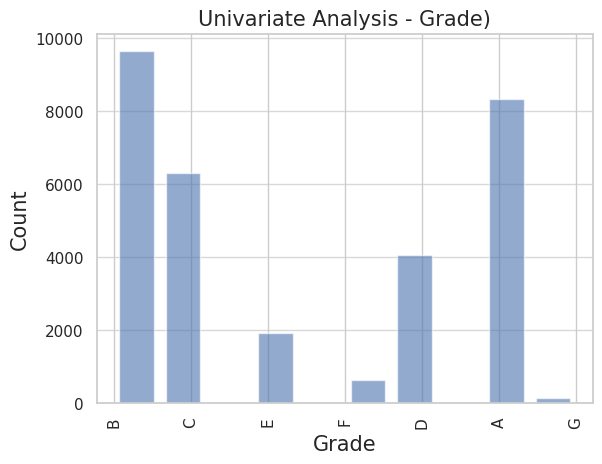

In [686]:
plt.hist(df['grade'], rwidth=0.75, alpha=0.6)
plt.xlabel('Grade', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.grid(axis='y',alpha=0.75)
plt.xticks(rotation='vertical')
plt.title('Univariate Analysis - Grade)', fontsize=15)
plt.show()

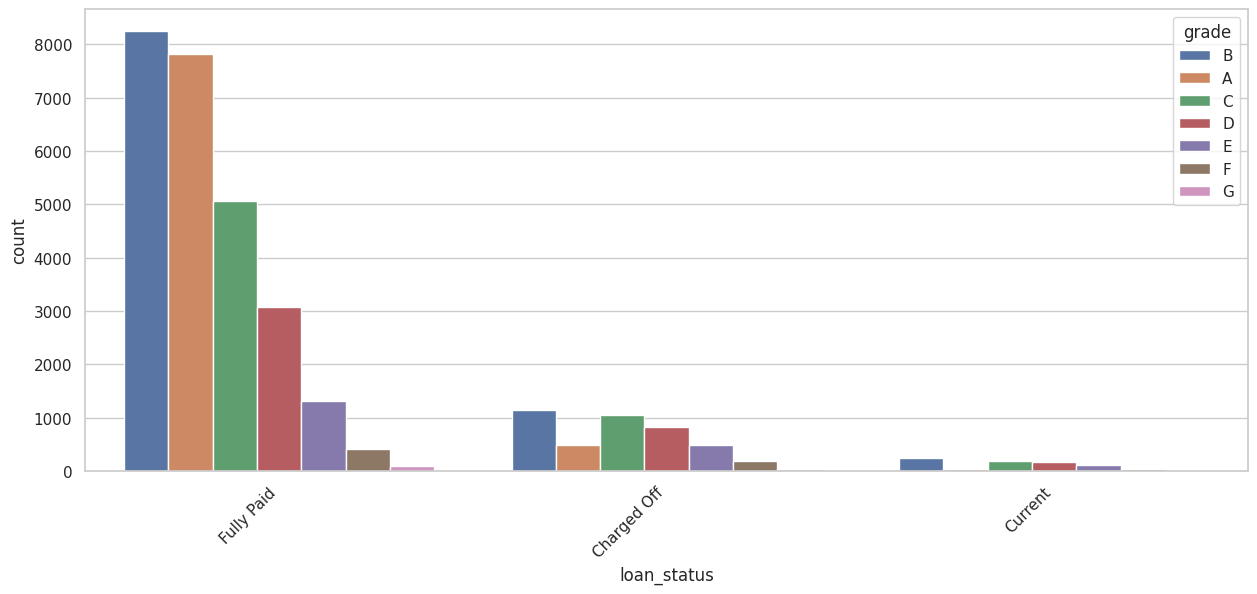

In [688]:
dfg = df.groupby(['grade', 'loan_status']).size().reset_index(name='count')
dfg = dfg.sort_values(by='count', ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6)) 
stateplt = sns.barplot(x='loan_status', y='count', hue='grade', data=dfg)
stateplt.set_xticklabels(stateplt.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show() 

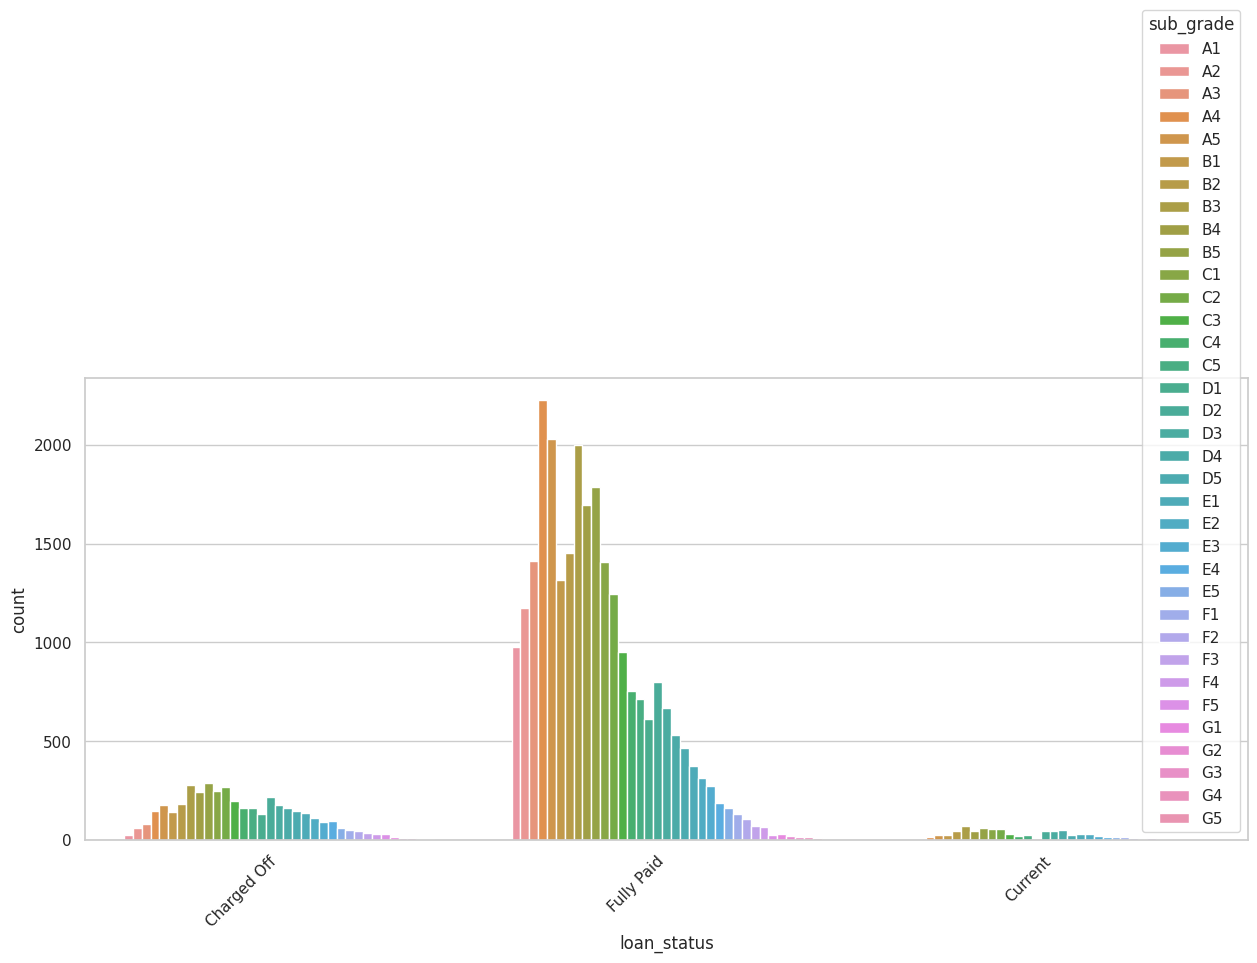

In [689]:
dfsg = df.groupby(['sub_grade', 'loan_status']).size().reset_index(name='count')
dfsg.sort_values(by='count', ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
stateplt = sns.barplot(x='loan_status', y='count', hue='sub_grade', data=dfsg)
stateplt.set_xticklabels(stateplt.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show() 

In [690]:

df_fp[['revol_bal','annual_inc']].corr()

,revol_bal,annual_inc
revol_bal,1.000000,0.368922
annual_inc,0.368922,1.000000


In [691]:
df_co[['revol_bal','annual_inc']].corr()

,revol_bal,annual_inc
revol_bal,1.000000,0.424053
annual_inc,0.424053,1.000000


In [692]:
df_c[['revol_bal','annual_inc']].corr()

,revol_bal,annual_inc
revol_bal,1.00000,0.30345
annual_inc,0.30345,1.00000


<Axes: xlabel='sub_grade'>

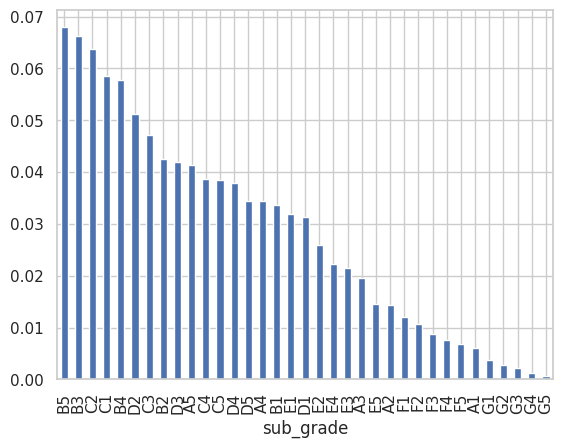

In [693]:
(df_co['sub_grade'].value_counts()/len(df_co)).plot.bar()

<Axes: xlabel='sub_grade'>

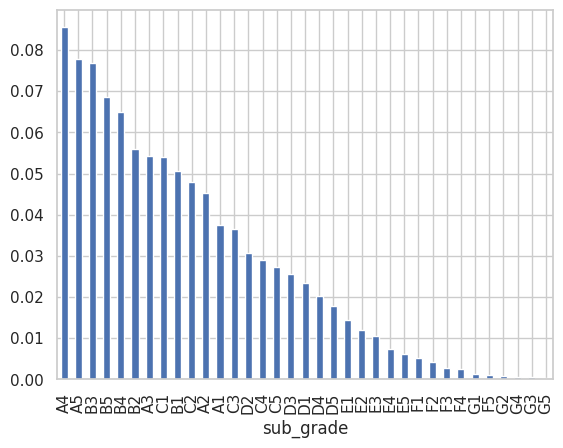

In [694]:
(df_fp['sub_grade'].value_counts()/len(df_fp)).plot.bar()

In [695]:
#df.emp_title.value_counts().plot.bar


df2.groupby(by=['emp_title','loan_status'])
#df2.rank_LS_by_city_emp =
df2.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,chargeoff_within_12_mths,pub_rec_bankruptcies,tax_liens,issue_d_month,issue_d_year,last_pymnt_d_month,last_pymnt_d_year,last_credit_pull_d_month,last_credit_pull_d_year,earliest_cr_line_month,earliest_cr_line_year
0,1077501,1296599,5000,5000,4975.0,36,10.65,162.87,B,B2,NaN,10,RENT,24000.0,Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.7,9,0.0,0.0,5863.155187,5833.84,5000.00,863.16,0.00,0.0,0.0,Jan-15,171.62,NaN,May-16,0.0,0.0,0.0,0.0,Dec,11,Jan,15,May,16,Jan,85
2,1077175,1313524,2400,2400,2400.0,36,15.96,84.33,C,C5,NaN,10,RENT,12252.0,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.5,10,0.0,0.0,3005.666844,3005.67,2400.00,605.67,0.00,0.0,0.0,Jun-14,649.91,NaN,May-16,0.0,0.0,0.0,0.0,Dec,11,Jun,14,May,16,Nov,01
3,1076863,1277178,10000,10000,10000.0,36,13.49,339.31,C,C1,AIR RESOURCES BOARD,10,RENT,49200.0,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.0,NaN,10,0,5598,21.0,37,0.0,0.0,12231.890000,12231.89,10000.00,2214.92,16.97,0.0,0.0,Jan-15,357.48,NaN,Apr-16,0.0,0.0,0.0,0.0,Dec,11,Jan,15,Apr,16,Feb,96
6,1069639,1304742,7000,7000,7000.0,60,15.96,170.08,C,C5,Southern Star Photography,8,RENT,47004.0,Not Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/18/11 > I am planning o...,debt_consolidation,Loan,280xx,NC,23.51,0,Jul-05,1,NaN,NaN,7,0,17726,85.6,11,0.0,0.0,10110.840000,10110.84,6985.61,3125.23,0.00,0.0,0.0,May-16,1313.76,NaN,May-16,0.0,0.0,0.0,0.0,Dec,11,May,16,May,16,Jul,05
7,1072053,1288686,3000,3000,3000.0,36,18.64,109.43,E,E1,MKC Accounting,9,RENT,48000.0,Source Verified,Dec-11,Fully Paid,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/16/11 > Downpayment for...,car,Car Downpayment,900xx,CA,5.35,0,Jan-07,2,NaN,NaN,4,0,8221,87.5,4,0.0,0.0,3939.135294,3939.14,3000.00,939.14,0.00,0.0,0.0,Jan-15,111.34,NaN,Dec-14,0.0,0.0,0.0,0.0,Dec,11,Jan,15,Dec,14,Jan,07


Segment Analysis can be done on "City Employes" to get default and income levels.

In [697]:
df.emp_title = df['emp_title'].isna()
df.emp_title = df.emp_title.astype('string')
df_city = df[df['emp_title'].str.startswith('city of')]
df_city = df_city.groupby(['emp_title', 'loan_status']).size().reset_index(name='count')
df_city = df_city.sort_values(by='count', ascending=False)
sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))  
stateplt = sns.barplot(x='loan_status', y='count', hue='emp_title', data=df_city)


stateplt.set_xticklabels(stateplt.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show() 

ValueError: min() arg is an empty sequence

<Figure size 1500x600 with 0 Axes>